# Implementing Research Paper: Predicting Mobile Money Transaction Fraud Using Machine Learning Algorithms
 DOI:10.1002/ail2.85

In [3]:
!pip install numpy>=1.24.3 scipy>=1.10.1 scikit-learn>=1.3.2 pytest>=7.2.2

In [4]:
!pip install imbalanced-learn

In [5]:
!pip install pyartemis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 90.1 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-expr 1.1.21 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you ha

In [43]:
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyartemis 0.1.5 requires networkx<3.0.0,>=2.8.8, but you have networkx 3.4.2 which is incompatible.
visions 0.8.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvi

In [47]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier    
from sklearn.tree import plot_tree
from imblearn.combine import SMOTEENN
import seaborn as sns
import matplotlib.pyplot as plt
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
from lime import lime_tabular

In [7]:
paysim_data = pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")
paysim_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
paysim_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Data preparation

In [9]:
# Exclude some features
drop_features = ["nameOrig", "nameDest", "isFlaggedFraud"]
paysim_data.drop(columns=drop_features, inplace=True)

In [10]:
# Apply Min-Max scaler on numerical features
numerical_features = ["amount", "oldbalanceDest", "newbalanceDest", "oldbalanceOrg", "newbalanceOrig"]
min_max_scaler = MinMaxScaler()
paysim_data[numerical_features] = min_max_scaler.fit_transform(paysim_data[numerical_features])

In [11]:
# One-Hot encode type column
encoded_types = pd.get_dummies(paysim_data["type"], prefix="type_")
paysim_data = pd.concat([paysim_data, encoded_types], axis = 1)
paysim_data.drop(columns=["type"], inplace=True)

In [12]:
# Seperate features and target
target = "isFraud"
X = paysim_data.drop(columns=[target])
y = paysim_data[target]

In [13]:
# Splitting data to train and test with ratio 60% for training and 40% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [14]:
# Perform smote enn on data to fix imbalance
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [15]:
# Exclude some features
drop_features = ["oldbalanceOrg", "newbalanceOrig", "step"]
X_train_resampled.drop(columns=drop_features, inplace=True)
X_test.drop(columns=drop_features, inplace=True)

In [16]:
X_train_resampled.head()

,amount,oldbalanceDest,newbalanceDest,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
0,0.000313,0.000000,0.000081,0,1,0,0,0
1,0.001225,0.003921,0.004237,0,1,0,0,0
2,0.000077,0.000000,0.000000,0,0,0,1,0
3,0.004115,0.000349,0.001417,0,0,0,0,1
4,0.000301,0.000000,0.000000,0,0,0,1,0


## Modeling

In [17]:
# Random Forest Parameters
max_depth = 8
n_estimators = 3

In [18]:
# Applying 5-fold cross validation for training model
kfold_obj = KFold()
kfold_splits = kfold_obj.split(X_train_resampled)
models_accuracies = []
for train_indicies, validation_indicies in kfold_splits:
    model_i = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    model_i.fit(X_train_resampled.iloc[train_indicies], y_train_resampled.iloc[train_indicies])
    y_pred = model_i.predict(X_train_resampled.iloc[validation_indicies])
    models_accuracies.append(accuracy_score(y_train_resampled.iloc[validation_indicies], y_pred))

In [19]:
# Validating stability of model across 5 folds
models_accuracies

[0.8557443170579928,
 0.8432360291262072,
 0.8980602461178966,
 0.7981969928853568,
 0.8042325156559053]

In [20]:
# Training model on whole training set
rf_model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=8, n_estimators=3)

In [21]:
# Predicting labels for test set
y_pred = rf_model.predict(X_test)

In [22]:
# Generating classification report for test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   2541782
           1       0.02      0.80      0.03      3266

    accuracy                           0.94   2545048
   macro avg       0.51      0.87      0.50   2545048
weighted avg       1.00      0.94      0.97   2545048



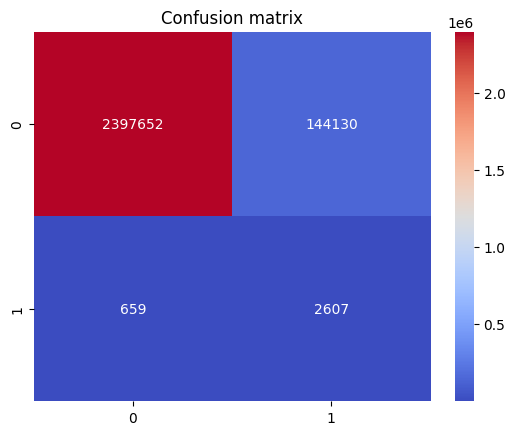

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="coolwarm", fmt="d")
plt.title("Confusion matrix")
plt.show()

## Interpretation

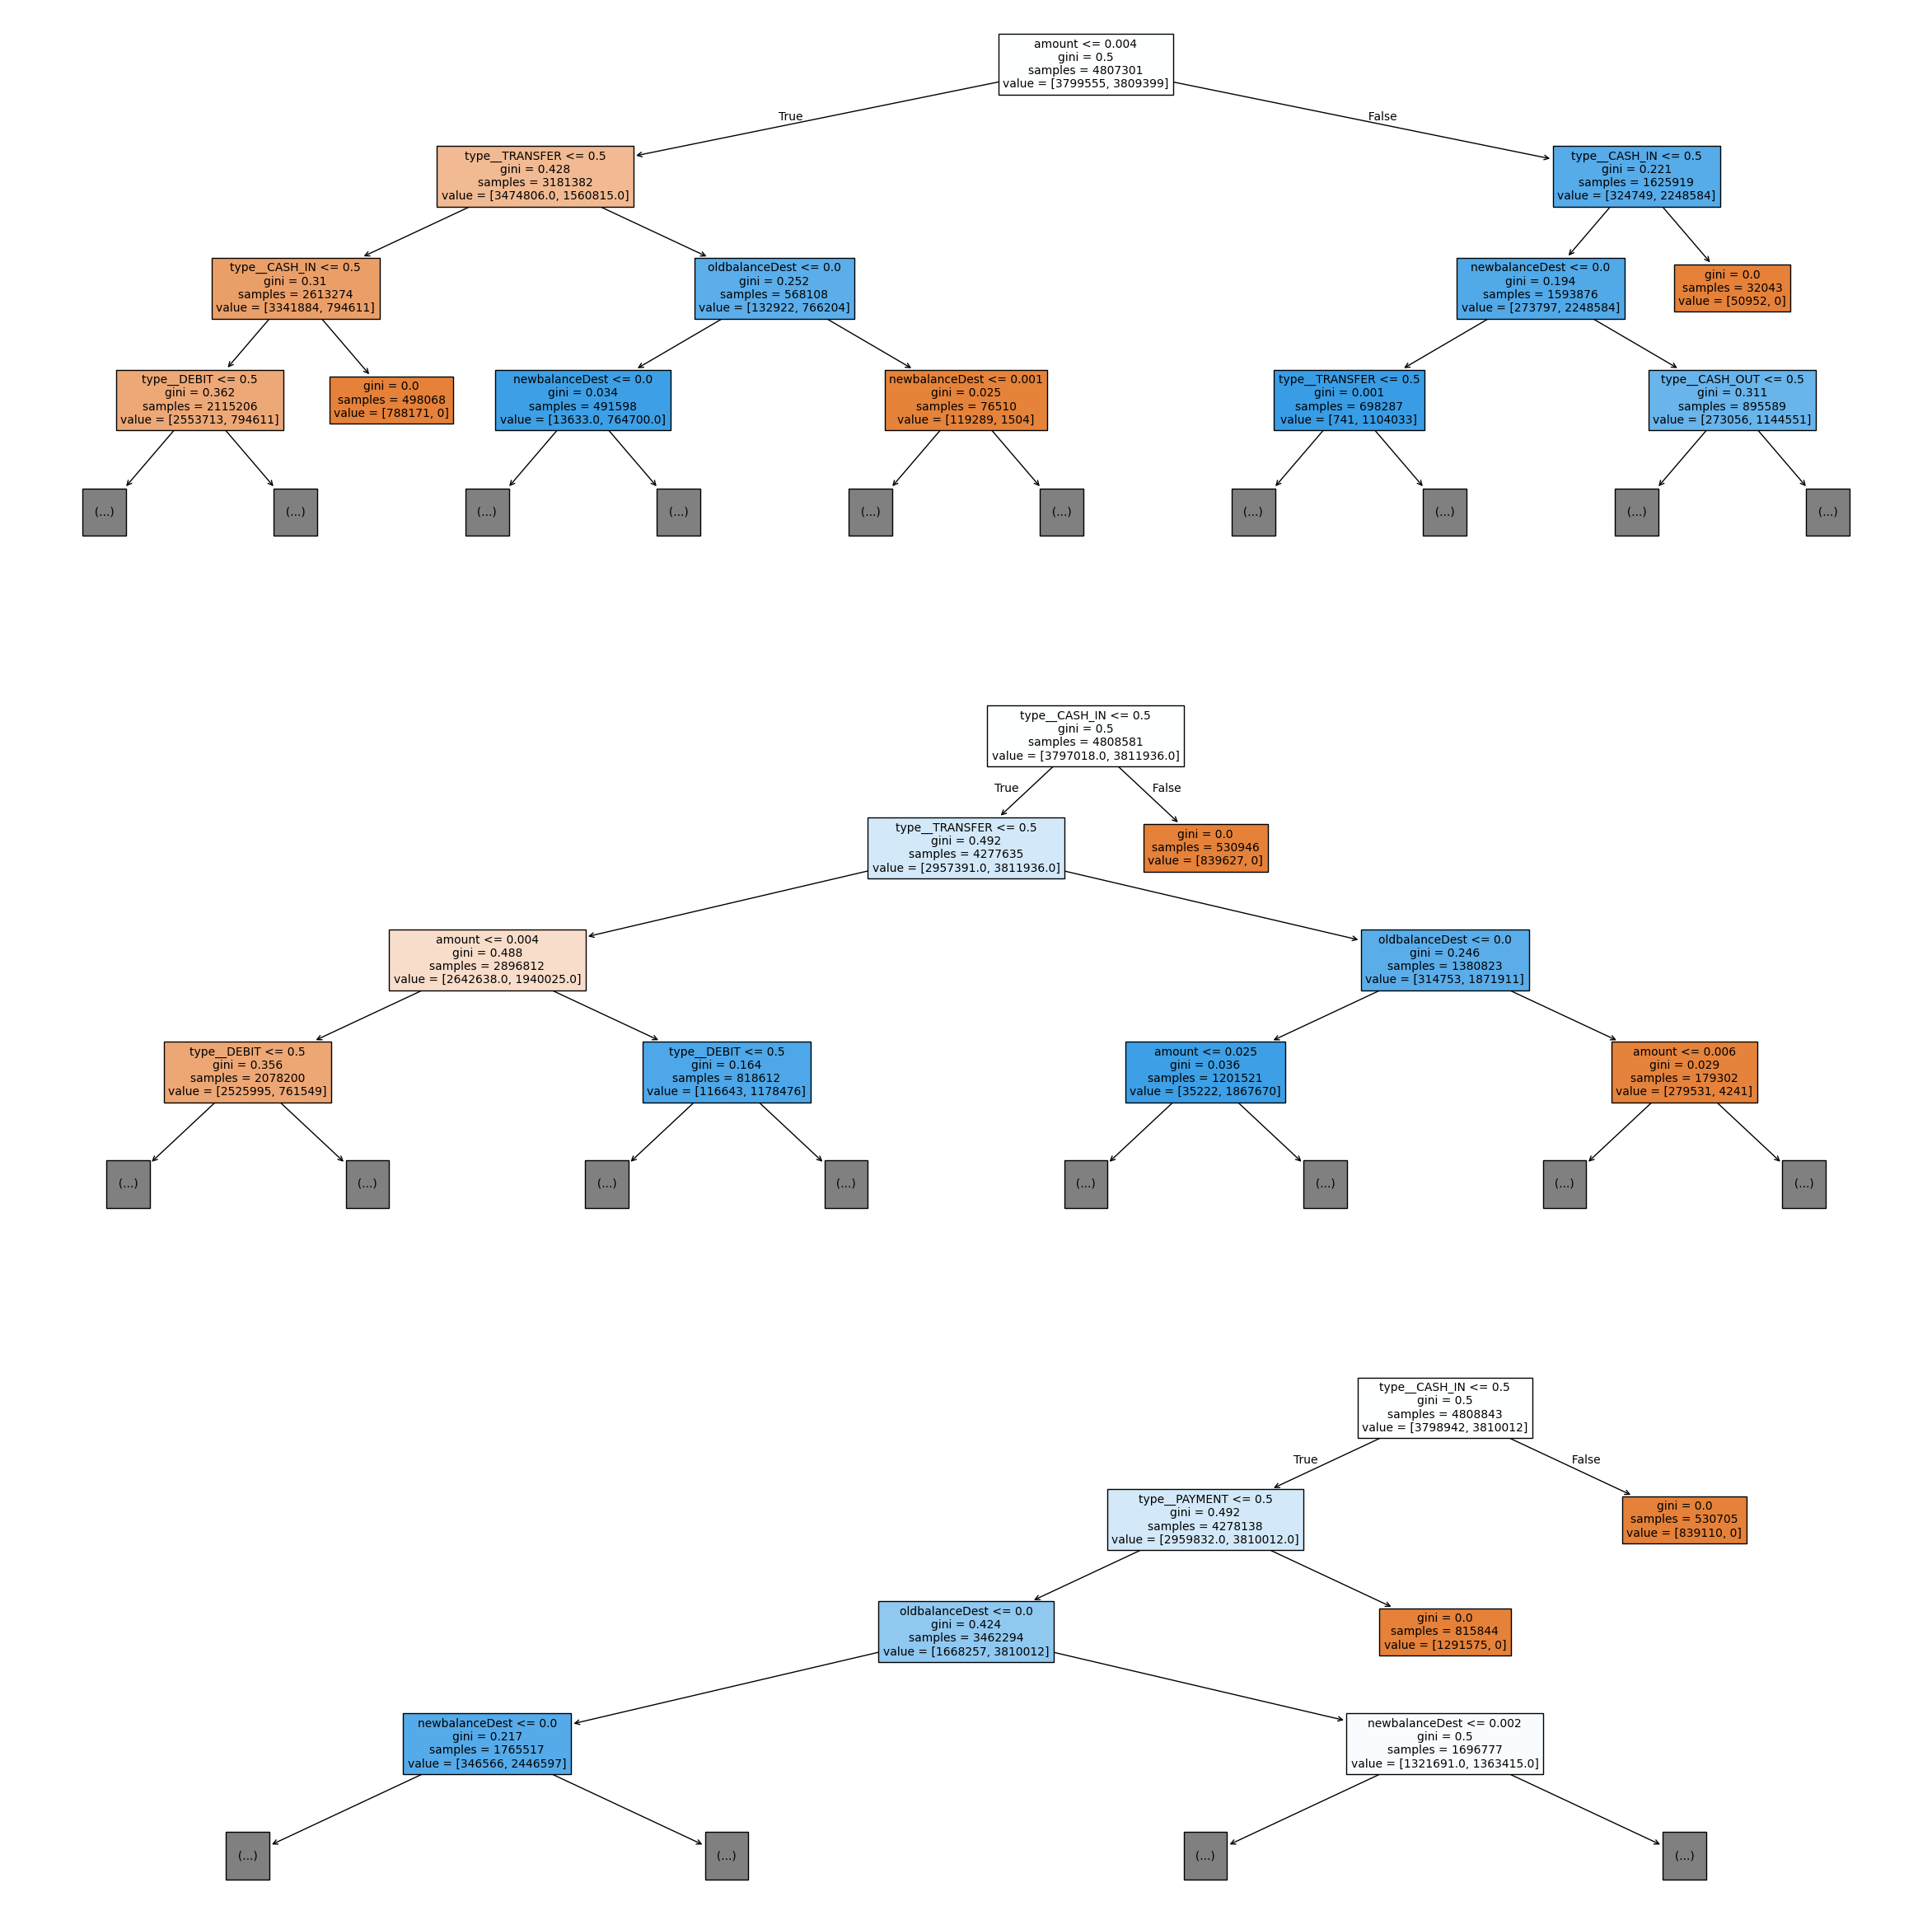

In [77]:
# Visualizing Trees
trees = rf_model.estimators_
plt.figure(figsize=(30, len(trees) * 10))
i = 1
for tree in trees:
    plt.subplot(len(trees), 1, i)
    _ = plot_tree(tree, filled=True, max_depth=3, fontsize=10, feature_names=X_train_resampled.columns)
    i += 1
plt.show()

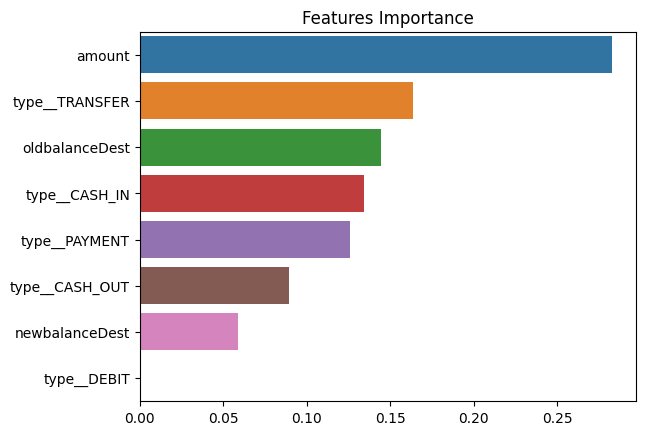

In [25]:
# Visualizing feature importances
sorted_features = X_train_resampled.columns.sort_values(key=lambda x : rf_model.feature_importances_, ascending=False)
sorted_importances = sorted(rf_model.feature_importances_, reverse=True)
sns.barplot(x=sorted_importances, y=sorted_features, orient='h')
plt.title("Features Importance")
plt.show()

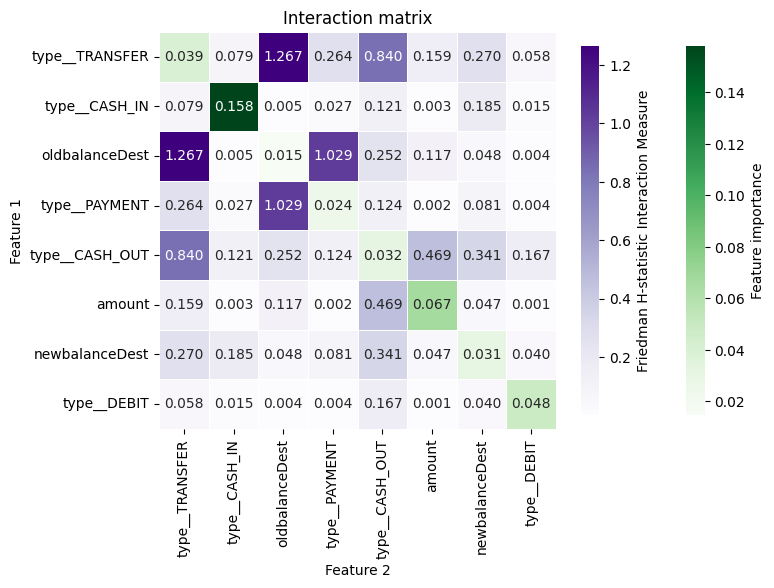

In [79]:
# Visualizing features interactions
h_stat = FriedmanHStatisticMethod()
h_stat.fit(rf_model, X_test.sample(100))
h_stat.plot()
plt.show()

In [52]:
# Building LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train_resampled.values,
    feature_names=X_train_resampled.columns.tolist(),
    class_names=["Not Fraud", "Fraud"],
    mode="classification"
)

In [75]:
# Apply LIME on non fraud example
normal_idx = 264914
explaination_normal = lime_explainer.explain_instance(X_test.loc[normal_idx], rf_model.predict_proba, num_features=8)
explaination_normal.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [81]:
X_test.loc[normal_idx]

amount            0.000126
oldbalanceDest    0.000000
newbalanceDest    0.000000
type__CASH_IN     0.000000
type__CASH_OUT    0.000000
type__DEBIT       0.000000
type__PAYMENT     1.000000
type__TRANSFER    0.000000
Name: 264914, dtype: float64

In [76]:
# Applying LIME on fraud example
fraud_idx = 1030272
explaination_fraud = lime_explainer.explain_instance(X_test.loc[fraud_idx], rf_model.predict_proba, num_features=8)
explaination_fraud.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [82]:
X_test.loc[fraud_idx]

amount            0.012659
oldbalanceDest    0.000487
newbalanceDest    0.003772
type__CASH_IN     0.000000
type__CASH_OUT    1.000000
type__DEBIT       0.000000
type__PAYMENT     0.000000
type__TRANSFER    0.000000
Name: 1030272, dtype: float64

## Discussion 

Our model achieved great performance in classifying transactions as fraud or not, with high recall for each class, which makes our model useful in real-world applications.

To interpret our results, we tried some techniques including visualizing the random forest estimators, visualizing model feature importance and interactions, and explaining local examples—one for fraud and one normal. The amount is the most important feature used by our model; when it increases, the probability of being fraud increases, and conversely, when it decreases, the probability of being fraud decreases. In addition, there are features like type_CASH_IN and type_PAYMENT when they are used in splitting, they ensure a pure branch that contains non-fraud samples, which is expected as no thief would deposit into a victim’s account or pay for them. The interaction matrix shows strong interaction between oldbalanceDest and type_TRANSFER because when there is a transfer and a small oldbalanceDest, it is probably a fraud.

When I interpreted an example of a non-fraud transaction, there was only one active feature, which was type_PAYMENT, and since it contributed to the Not Fraud class, our final output was non-fraud. On the other hand, we tried interpreting another example this time it was fraud—and in this example, the active features were type_CASH_OUT and amount, which contributed to the fraud class. Our model's output was fraud.
